### This notebook's purpose is to get the CALCE data in a workable format (in a dataframe, cleaned, battery type labeled etc.)

### Goals: (Add to this)
1. Get files from CALCE website into dataframe(s)
2. Add label for every cycle which battery this data came from 
3. Find/Remove empty cells  (delete the whole row or should we do interpolation?) (Might not even have empty cells)


All CS2 cells underwent the same charging profile which was a standard constant current/constant voltage protocol with a constant current rate of 0.5C until the voltage reached 4.2V and then 4.2V was sustained until the charging current dropped to below 0.05A. Unless specified, the discharge cut off voltage for these batteries was 2.7V. All the CS2 cells were randomly numbered and named accordingly. Name 'CS2_n' was given for the nth numbered CS2 cell. 

#### Imports:

In [16]:
import scipy.io
import os 
import pandas as pd
import zipfile
import requests
import xlrd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
import statistics as stats
from math import isclose
from pathlib import Path
%matplotlib inline

#### Notes:
To import .mat files into python:  
import scipy.io   
mat = scipy.io.loadmat('file.mat')  

To unzip files: look at SEDS HW2 (not sure if we will use this)


#### CS2 data (in excel format*)  
Look at CS2 data first. From the website, CS2_'n' was given to the nth numbered CS2 cell (identifies unique cells from eachother). Each cell was cycled multiple times. Excel files are named using the testing dates.  **Were the same cells cycled on different dates or was the continuous cycling data split into multiple excel files?**   

*CS2_8 and CS2_21 are in .txt format because they were cycled using a different system.

Starting with CS2_33, in excel file format

In [2]:
data1 = pd.read_excel("data/CS2_33/CS2_33_10_04_10.xlsx", sheet_name= "Channel_1-006")
#it looks like all of these have the sheet name channel_1-006, not just this specific excel file? 
#would be nice to create a function to iterate over all the files in a given file and import them, store them in variable. 

In [17]:
rootdir = Path('data')
# Return a list of regular files only, not directories
file_list = [f for f in rootdir.glob('**/*') if f.is_file()]

dictionary = []
for file in file_list:
    name = os.path.split(file)[1].split('.')[0]
    new_set = {name : pd.read_excel(file,1)}
    dictionary.append(new_set)
    print(name)
   


CS2_33_10_04_10
CS2_33_10_05_10
CS2_33_10_15_10
CS2_33_10_26_10
CS2_33_11_01_10
CS2_33_11_10_10
CS2_33_11_19_10
CS2_33_11_24_10
CS2_33_12_08_10
CS2_33_12_16_10
CS2_33_12_23_10
CS2_33_1_10_11
CS2_33_1_18_11
CS2_33_1_24_11
CS2_33_1_28_11
CS2_33_2_2_11
CS2_33_8_17_10
CS2_33_8_18_10
CS2_33_8_19_10
CS2_33_8_30_10
CS2_33_9_17_10
CS2_33_9_27_10
CS2_33_9_7_10


PermissionError: [Errno 13] Permission denied: 'data\\CS2_33\\~$CS2_33_10_26_10.xlsx'

In [3]:
data1['Cycle_Index'].max()
#this gives the number of cycles they ran

23

In [4]:
#we will need to clean the data so that dq/dv does not come back with weird data, ie we need to make sure the dq/dv isn't being 
# calculated between identical voltage values (because then dv = 0)
# (dq/dt)/(dv/dt)= dq/dv 
# (dq/dt) = current 


# calculate dv, find values close to 0, delete those rows, reindex, calculate dv again, 

New Column- To calculate dq/dv do discharge/charge capacity/ dv. calculate dv first. Ask robert whether to use discharge or charge capacity to calculate this. or do both and compare. Maybe ask user which capacity to use between discharge and charge - depends on system (i.e. Maccor) , which anode or cathode they are looking at etc. 

In [5]:
data1['dV'] = None 

In [6]:
data1.loc[2, ('Voltage(V)')]

3.4519877433776855

In [7]:
range(len(data1))

range(0, 10759)

In [8]:
for i in range(1,len(data1)): 
    data1.loc[i, ('dV')] = data1.loc[i, ('Voltage(V)')] - data1.loc[i-1, ('Voltage(V)')]


In [9]:
data1['dQ/dV'] = data1['Discharge_Capacity(Ah)']/data1['dV']

In [10]:
data1.head()

,Data_Point,Test_Time(s),Date_Time,Step_Time(s),Step_Index,Cycle_Index,Current(A),Voltage(V),Charge_Capacity(Ah),Discharge_Capacity(Ah),Charge_Energy(Wh),Discharge_Energy(Wh),dV/dt(V/s),Internal_Resistance(Ohm),Is_FC_Data,AC_Impedance(Ohm),ACI_Phase_Angle(Deg),dV,dQ/dV
0,1,30.000116,2010-09-27 14:12:48,30.000117,1,1,0.000000,3.451826,0.000000,0.0,0.000000,0.0,-0.000032,0.0,0,0,0,None,NaN
1,2,60.015409,2010-09-27 14:13:18,60.015410,1,1,0.000000,3.451826,0.000000,0.0,0.000000,0.0,0.000000,0.0,0,0,0,0,NaN
2,3,90.030676,2010-09-27 14:13:48,90.030677,1,1,0.000000,3.451988,0.000000,0.0,0.000000,0.0,0.000000,0.0,0,0,0,0.000161886,0
3,4,120.014848,2010-09-27 14:14:18,120.014848,1,1,0.000000,3.451826,0.000000,0.0,0.000000,0.0,-0.000032,0.0,0,0,0,-0.000161886,-0
4,5,150.030659,2010-09-27 14:14:48,30.015332,2,1,0.550025,3.584821,0.004585,0.0,0.016314,0.0,0.001264,0.0,0,0,0,0.132995,0


In [11]:
data1 = data1.replace([np.inf, -np.inf], np.nan).dropna(subset=['dQ/dV'])

In [12]:
data1 = data1.reset_index(drop = True)

In [13]:
data1['dQ/dV'].mean()

113.589882961996

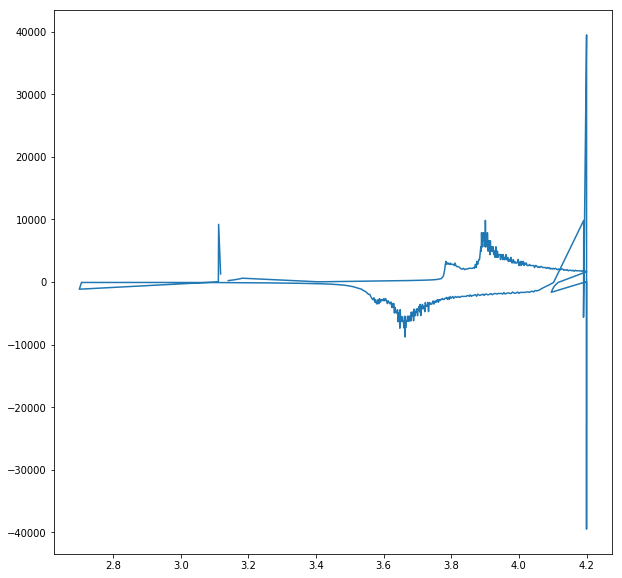

In [14]:
df1 = pd.DataFrame() 
for i in range(1,len(data1)):
    if data1.loc[i, ('Cycle_Index')] == 7:
        df1 = df1.append(data1.loc[i])
        
fig = plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
myplot = plt.plot(df1['Voltage(V)'], df1['dQ/dV'])

In [15]:
for i in range(1,len(data1)):
    if isclose(data1.loc[i, ('dV')], 0, abs_tol = 10**-3):
        data1 = data1.drop(index = i)


In [16]:
len(data1)

9758

In [17]:
data1['dQ/dV-discharge cap'] = data1['Discharge_Capacity(Ah)']/data1['dV']

In [18]:
data1['dQ/dV-charge cap'] = data1['Charge_Capacity(Ah)']/data1['dV']

In [19]:
data1

,Data_Point,Test_Time(s),Date_Time,Step_Time(s),Step_Index,Cycle_Index,Current(A),Voltage(V),Charge_Capacity(Ah),Discharge_Capacity(Ah),...,Discharge_Energy(Wh),dV/dt(V/s),Internal_Resistance(Ohm),Is_FC_Data,AC_Impedance(Ohm),ACI_Phase_Angle(Deg),dV,dQ/dV,dQ/dV-discharge cap,dQ/dV-charge cap
0,3,90.030676,2010-09-27 14:13:48,90.030677,1,1,0.000000,3.451988,0.000000,0.000000,...,0.000000,0.000000,0.000000,0,0,0,0.000162,0.000000,0.000000,0.000000
2,5,150.030659,2010-09-27 14:14:48,30.015332,2,1,0.550025,3.584821,0.004585,0.000000,...,0.000000,0.001264,0.000000,0,0,0,0.132995,0.000000,0.000000,0.034475
3,6,180.045864,2010-09-27 14:15:18,60.030537,2,1,0.549845,3.625319,0.009170,0.000000,...,0.000000,0.000972,0.000000,0,0,0,0.040498,0.000000,0.000000,0.226432
4,7,210.061288,2010-09-27 14:15:48,90.045961,2,1,0.549845,3.658041,0.013755,0.000000,...,0.000000,0.000778,0.000000,0,0,0,0.032722,0.000000,0.000000,0.420359
5,8,240.076447,2010-09-27 14:16:18,120.061120,2,1,0.549845,3.685742,0.018340,0.000000,...,0.000000,0.000680,0.000000,0,0,0,0.027701,0.000000,0.000000,0.662079
6,9,270.091760,2010-09-27 14:16:48,150.076433,2,1,0.549845,3.709716,0.022925,0.000000,...,0.000000,0.000583,0.000000,0,0,0,0.023975,0.000000,0.000000,0.956223
7,10,300.107032,2010-09-27 14:17:18,180.091705,2,1,0.550205,3.731099,0.027510,0.000000,...,0.000000,0.000551,0.000000,0,0,0,0.021383,0.000000,0.000000,1.286540
8,11,330.122452,2010-09-27 14:17:48,210.107125,2,1,0.550025,3.749890,0.032095,0.000000,...,0.000000,0.000421,0.000000,0,0,0,0.018791,0.000000,0.000000,1.708014
9,12,360.137626,2010-09-27 14:18:18,240.122299,2,1,0.549845,3.766737,0.036680,0.000000,...,0.000000,0.000389,0.000000,0,0,0,0.016847,0.000000,0.000000,2.177242
10,13,390.152946,2010-09-27 14:18:48,270.137619,2,1,0.549845,3.779859,0.041265,0.000000,...,0.000000,0.000324,0.000000,0,0,0,0.013121,0.000000,0.000000,3.144901


Drop Rows With N/A or infinity in dq/dv-discharge cap row. First replace inf values for N/a values so can use dropna

In [20]:
data1.replace([np.inf, -np.inf], np.nan)

,Data_Point,Test_Time(s),Date_Time,Step_Time(s),Step_Index,Cycle_Index,Current(A),Voltage(V),Charge_Capacity(Ah),Discharge_Capacity(Ah),...,Discharge_Energy(Wh),dV/dt(V/s),Internal_Resistance(Ohm),Is_FC_Data,AC_Impedance(Ohm),ACI_Phase_Angle(Deg),dV,dQ/dV,dQ/dV-discharge cap,dQ/dV-charge cap
0,3,90.030676,2010-09-27 14:13:48,90.030677,1,1,0.000000,3.451988,0.000000,0.000000,...,0.000000,0.000000,0.000000,0,0,0,0.000162,0.000000,0.000000,0.000000
2,5,150.030659,2010-09-27 14:14:48,30.015332,2,1,0.550025,3.584821,0.004585,0.000000,...,0.000000,0.001264,0.000000,0,0,0,0.132995,0.000000,0.000000,0.034475
3,6,180.045864,2010-09-27 14:15:18,60.030537,2,1,0.549845,3.625319,0.009170,0.000000,...,0.000000,0.000972,0.000000,0,0,0,0.040498,0.000000,0.000000,0.226432
4,7,210.061288,2010-09-27 14:15:48,90.045961,2,1,0.549845,3.658041,0.013755,0.000000,...,0.000000,0.000778,0.000000,0,0,0,0.032722,0.000000,0.000000,0.420359
5,8,240.076447,2010-09-27 14:16:18,120.061120,2,1,0.549845,3.685742,0.018340,0.000000,...,0.000000,0.000680,0.000000,0,0,0,0.027701,0.000000,0.000000,0.662079
6,9,270.091760,2010-09-27 14:16:48,150.076433,2,1,0.549845,3.709716,0.022925,0.000000,...,0.000000,0.000583,0.000000,0,0,0,0.023975,0.000000,0.000000,0.956223
7,10,300.107032,2010-09-27 14:17:18,180.091705,2,1,0.550205,3.731099,0.027510,0.000000,...,0.000000,0.000551,0.000000,0,0,0,0.021383,0.000000,0.000000,1.286540
8,11,330.122452,2010-09-27 14:17:48,210.107125,2,1,0.550025,3.749890,0.032095,0.000000,...,0.000000,0.000421,0.000000,0,0,0,0.018791,0.000000,0.000000,1.708014
9,12,360.137626,2010-09-27 14:18:18,240.122299,2,1,0.549845,3.766737,0.036680,0.000000,...,0.000000,0.000389,0.000000,0,0,0,0.016847,0.000000,0.000000,2.177242
10,13,390.152946,2010-09-27 14:18:48,270.137619,2,1,0.549845,3.779859,0.041265,0.000000,...,0.000000,0.000324,0.000000,0,0,0,0.013121,0.000000,0.000000,3.144901


In [21]:
data1 = data1.replace([np.inf, -np.inf], np.nan).dropna(subset=["dQ/dV-discharge cap"])

In [22]:
data1.dropna(subset=['dQ/dV-discharge cap'], inplace= True)

In [23]:
data1['dQ/dV-discharge cap'].max()

20791.478321355844

In [24]:
data1.shape

(9758, 21)

In [25]:
data1.head()

,Data_Point,Test_Time(s),Date_Time,Step_Time(s),Step_Index,Cycle_Index,Current(A),Voltage(V),Charge_Capacity(Ah),Discharge_Capacity(Ah),...,Discharge_Energy(Wh),dV/dt(V/s),Internal_Resistance(Ohm),Is_FC_Data,AC_Impedance(Ohm),ACI_Phase_Angle(Deg),dV,dQ/dV,dQ/dV-discharge cap,dQ/dV-charge cap
0,3,90.030676,2010-09-27 14:13:48,90.030677,1,1,0.000000,3.451988,0.000000,0.0,...,0.0,0.000000,0.0,0,0,0,0.000162,0.0,0.0,0.000000
2,5,150.030659,2010-09-27 14:14:48,30.015332,2,1,0.550025,3.584821,0.004585,0.0,...,0.0,0.001264,0.0,0,0,0,0.132995,0.0,0.0,0.034475
3,6,180.045864,2010-09-27 14:15:18,60.030537,2,1,0.549845,3.625319,0.009170,0.0,...,0.0,0.000972,0.0,0,0,0,0.040498,0.0,0.0,0.226432
4,7,210.061288,2010-09-27 14:15:48,90.045961,2,1,0.549845,3.658041,0.013755,0.0,...,0.0,0.000778,0.0,0,0,0,0.032722,0.0,0.0,0.420359
5,8,240.076447,2010-09-27 14:16:18,120.061120,2,1,0.549845,3.685742,0.018340,0.0,...,0.0,0.000680,0.0,0,0,0,0.027701,0.0,0.0,0.662079


Reindex and calculate dV again 

In [26]:
data1 = data1.reset_index(drop = True)

In [27]:
for i in range(1,len(data1)): 
    data1.loc[i, ('dV')] = data1.loc[i, ('Voltage(V)')] - data1.loc[i-1, ('Voltage(V)')]

Plot

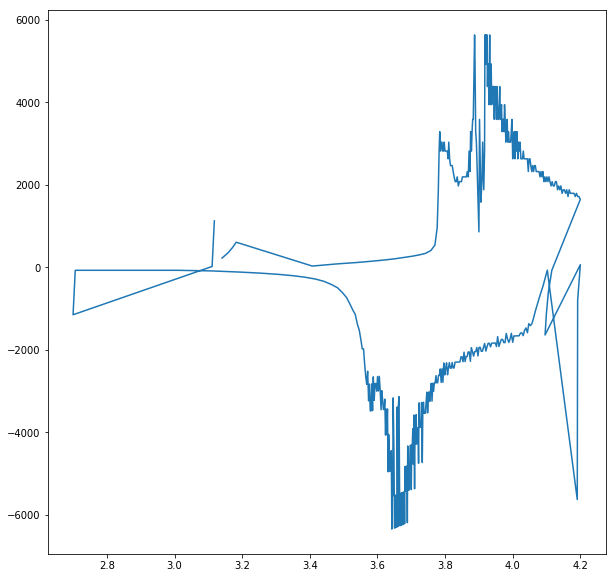

In [28]:
df1 = pd.DataFrame() 
for i in range(1,len(data1)):
    if data1.loc[i, ('Cycle_Index')] == 7:
        df1 = df1.append(data1.loc[i])
        
fig = plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
myplot = plt.plot(df1['Voltage(V)'], df1['Discharge_Capacity(Ah)']/df1['dV'])

In [ ]:
data1['dQ/dV-charge cap'].max()

In [ ]:
data1['Cycle_Index'].max()

In [ ]:
gb = data1.groupby(by = ['Cycle_Index'])

In [ ]:
print(gb)

In [ ]:
for i in range(1, data1['Cycle_Index'].max() + 1):
    print(i)
    

# Ted's stuff

## Random coding I did to get a workable dataframe, ignore

In [33]:
df1.shape

(435, 21)

In [46]:
df1_r = df1.reset_index(drop=True)
df1_r.head()

,ACI_Phase_Angle(Deg),AC_Impedance(Ohm),Charge_Capacity(Ah),Charge_Energy(Wh),Current(A),Cycle_Index,Data_Point,Date_Time,Discharge_Capacity(Ah),Discharge_Energy(Wh),...,Is_FC_Data,Step_Index,Step_Time(s),Test_Time(s),Voltage(V),dQ/dV,dQ/dV-charge cap,dQ/dV-discharge cap,dV,dV/dt(V/s)
0,0.0,0.0,6.376067,25.312912,0.000000,7.0,2849.0,2010-09-28 16:01:16,6.385272,23.90668,...,0.0,1.0,30.015283,92931.549133,3.140316,221.444942,221.125700,221.444942,0.028835,0.000648
1,0.0,0.0,6.376067,25.312912,0.000000,7.0,2850.0,2010-09-28 16:01:46,6.385272,23.90668,...,0.0,1.0,60.030597,92961.564447,3.158459,351.942557,351.435185,351.942557,0.018143,0.000421
2,0.0,0.0,6.376067,25.312912,0.000000,7.0,2851.0,2010-09-28 16:02:16,6.385272,23.90668,...,0.0,1.0,90.045844,92991.579694,3.171742,480.700951,480.007957,480.700951,0.013283,0.000259
3,0.0,0.0,6.376067,25.312912,0.000000,7.0,2852.0,2010-09-28 16:02:46,6.385272,23.90668,...,0.0,1.0,120.014250,93021.548100,3.182272,606.416375,605.542145,606.416375,0.010530,0.000227
4,0.0,0.0,6.380652,25.328267,0.550025,7.0,2853.0,2010-09-28 16:03:17,6.385272,23.90668,...,0.0,2.0,30.015273,93051.564200,3.407278,28.378188,28.357652,28.378188,0.225006,0.002559


In [49]:
df1_r.loc[2:4, 'Voltage(V)']

2    3.171742
3    3.182272
4    3.407278
Name: Voltage(V), dtype: float64

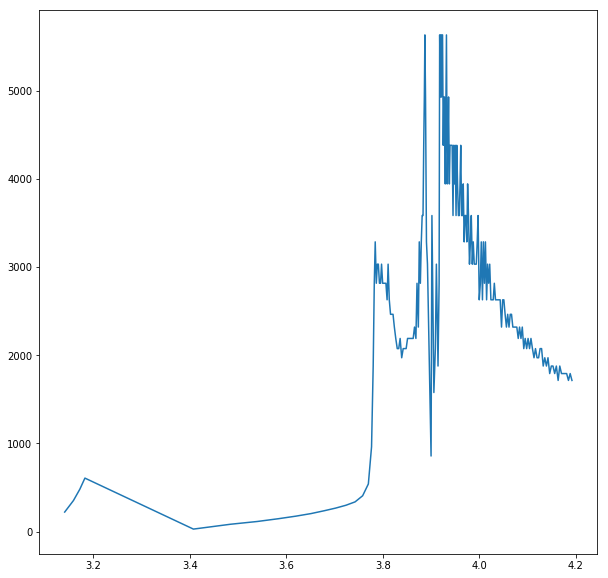

In [55]:
fig = plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
plt_r = range(190)
myplot = plt.plot(df1_r.loc[plt_r,'Voltage(V)'], df1_r.loc[plt_r, 'Discharge_Capacity(Ah)']/df1_r.loc[plt_r, 'dV'])

In [57]:
df2 = df1_r.head(190)
df2.head()

,ACI_Phase_Angle(Deg),AC_Impedance(Ohm),Charge_Capacity(Ah),Charge_Energy(Wh),Current(A),Cycle_Index,Data_Point,Date_Time,Discharge_Capacity(Ah),Discharge_Energy(Wh),...,Is_FC_Data,Step_Index,Step_Time(s),Test_Time(s),Voltage(V),dQ/dV,dQ/dV-charge cap,dQ/dV-discharge cap,dV,dV/dt(V/s)
0,0.0,0.0,6.376067,25.312912,0.000000,7.0,2849.0,2010-09-28 16:01:16,6.385272,23.90668,...,0.0,1.0,30.015283,92931.549133,3.140316,221.444942,221.125700,221.444942,0.028835,0.000648
1,0.0,0.0,6.376067,25.312912,0.000000,7.0,2850.0,2010-09-28 16:01:46,6.385272,23.90668,...,0.0,1.0,60.030597,92961.564447,3.158459,351.942557,351.435185,351.942557,0.018143,0.000421
2,0.0,0.0,6.376067,25.312912,0.000000,7.0,2851.0,2010-09-28 16:02:16,6.385272,23.90668,...,0.0,1.0,90.045844,92991.579694,3.171742,480.700951,480.007957,480.700951,0.013283,0.000259
3,0.0,0.0,6.376067,25.312912,0.000000,7.0,2852.0,2010-09-28 16:02:46,6.385272,23.90668,...,0.0,1.0,120.014250,93021.548100,3.182272,606.416375,605.542145,606.416375,0.010530,0.000227
4,0.0,0.0,6.380652,25.328267,0.550025,7.0,2853.0,2010-09-28 16:03:17,6.385272,23.90668,...,0.0,2.0,30.015273,93051.564200,3.407278,28.378188,28.357652,28.378188,0.225006,0.002559


In [58]:
df2.size

3990

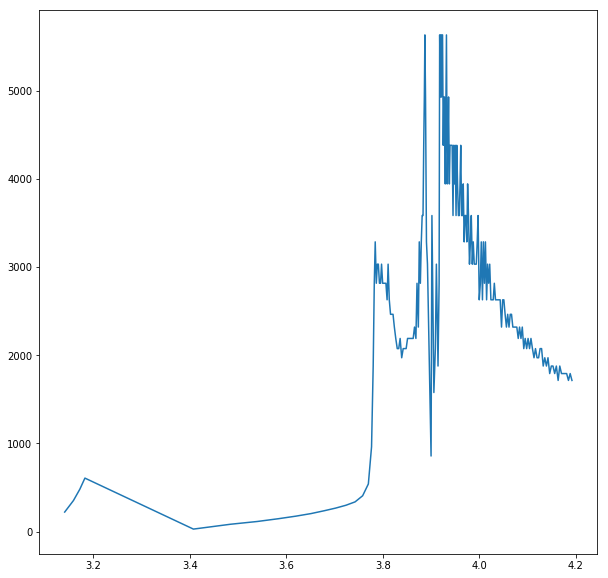

In [59]:
fig = plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
myplot = plt.plot(df2['Voltage(V)'], df2['Discharge_Capacity(Ah)']/df2['dV'])

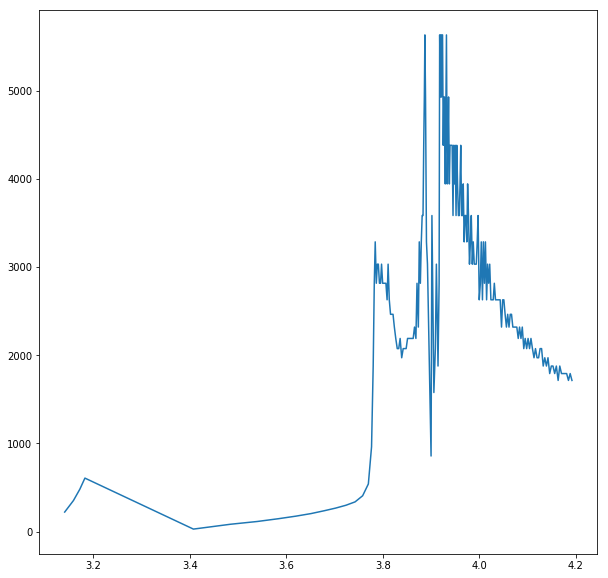

In [61]:
sig_prac = pd.DataFrame({'Voltage': df2['Voltage(V)'], 'dQdV': df2['Discharge_Capacity(Ah)']/df2['dV']})
fig = plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
myplot = plt.plot(sig_prac['Voltage'], sig_prac['dQdV'])

In [62]:
import scipy.signal

function has two parameters, the frame width and the order. Frame width needs to be odd and order needs to be less than frame width.

increaseing frame width and decreasing order smooths key features out of the data. Decreasing frame width and increasing order makes the data too noisy. For this dataset, I went with a framelength of 13 and an order of 3, but that was based on trial and error. A more quantitative way of choosing parameters for this would be useful.

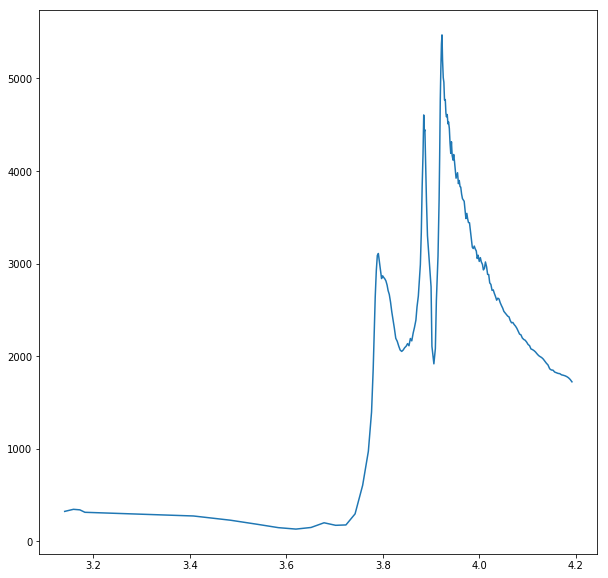

In [89]:
sig_prac['dQdV filt'] = pd.Series(scipy.signal.savgol_filter(sig_prac['dQdV'],13,3))
fig = plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
myplot = plt.plot(sig_prac['Voltage'], sig_prac['dQdV filt'])